## Content Based Filtering
영화의 콘텐츠(overview, cast, crew, keyword, tagline etc) 를 사용하여 다른 영화와 유사성을 찾고, 유사할 가능성이 가장 높은 영화를 추천

### Plot description based Recommender
모든 영화-영화 쌍의 유사성 점수를 계산하고 이를 기반으로 영화 추천

In [1]:
import pandas as pd
import numpy as np

In [2]:
df1 = pd.read_csv('../input/tmdb-movie-metadata/tmdb_5000_credits.csv')
df2 = pd.read_csv('../input/tmdb-movie-metadata/tmdb_5000_movies.csv')

In [3]:
df2['overview'].head(5)

0    In the 22nd century, a paraplegic Marine is di...
1    Captain Barbossa, long believed to be dead, ha...
2    A cryptic message from Bond’s past sends him o...
3    Following the death of District Attorney Harve...
4    John Carter is a war-weary, former military ca...
Name: overview, dtype: object

### compute Term Frequency-Inverse Document Frequency (TF-IDF) vectors for each overview
- TF(term frequency) = term instances/total instances
- IDF(Inverse Document Frequency) = number of documents/documents with term
- overall importance of each word = TF * IDF
  - 각 열은 개요에 쓰인 단어
  - 각 행은 영화를 나타냄
  
This is done to reduce the importance of words that occur frequently in plot overviews and therefore, their significance in computing the final similarity score.

In [4]:
#Import TfIdfVectorizer from scikit-learn
from sklearn.feature_extraction.text import TfidfVectorizer

#Define a TF-IDF Vectorizer Object. Remove all english stop words such as 'the', 'a'
tfidf = TfidfVectorizer(stop_words='english')

#Replace NaN with an empty string
df2['overview'] = df2['overview'].fillna('')

#Construct the required TF-IDF matrix by fitting and transforming the data
tfidf_matrix = tfidf.fit_transform(df2['overview'])

#Output the shape of tfidf_matrix
tfidf_matrix.shape

(4803, 20978)

데이터 세트에서 4800 편의 영화를 설명하는 데 20,000 개 이상의 다른 단어가 사용

### cosine similarity
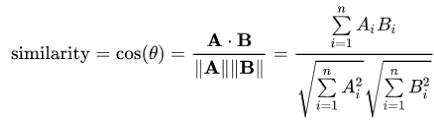

TF-IDF vectorizer를 사용했기 때문에, 내적을 계산하면 코사인 유사성 점수를 직접 얻을 수 있다.

In [5]:
# Import linear_kernel
from sklearn.metrics.pairwise import linear_kernel

# Compute the cosine similarity matrix
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)

In [8]:
# Construct a reverse map of indices and movie titles
indices = pd.Series(df2.index, index=df2['title']).drop_duplicates()

In [9]:
# 영화 제목을 입력 받아 가장 유사한 10개의 영화 목록을 출력하는 함수 정의
def get_recommendations(title, cosine_sim=cosine_sim):
    # Get the index of the movie that matches the title
    idx = indices[title]

    # Get the pairwsie similarity scores of all movies with that movie
    sim_scores = list(enumerate(cosine_sim[idx]))

    # Sort the movies based on the similarity scores
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # Get the scores of the 10 most similar movies
    sim_scores = sim_scores[1:11]

    # Get the movie indices
    movie_indices = [i[0] for i in sim_scores]

    # Return the top 10 most similar movies
    return df2['title'].iloc[movie_indices]